# Import libraries

In [1]:
import pandas as pd
import numpy as np
from itertools import cycle
import time
import statistics

import sklearn
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn import model_selection
from sklearn import feature_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score
from scipy import interp
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

%load_ext autoreload
%autoreload 2
%matplotlib inline
matplotlib.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

## Import the custom helper files

In [2]:
from algorithm_helpers import *
from visualisation_helpers import *

# Load the dataset

In [3]:
path = '../../datasets/vehicles.csv'  # Path to dataset
df = pd.read_csv(path)

In [4]:
X = df.drop(labels='Class', axis=1)  # Drop the target attribute from the X variable
# We are not normalising the data for this particular notebook.
y = df.Class  # The target attribute to be predicted

**No normalization?** Yes, because the classifier(s) I will be using do not require scaled data.

# Importance score prediction and analysis

**How do we classify a particular datapoint as important?**

Given a particular dataset, a datapoint is important if its exclusion affects the overall distribution of the dataset. In other words, every **unique** datapoint is **important**, which also means that the rest of the dataset cannot be used to estimate an important datapoint. An unimportant or insignificant datapoint is one which falls right into the data distribution of the dataset and does not provide any new meaning to it.

One way to get an estimate of the importance of **a particular datapoint** is to train a classifier with it and then without it and finally compare the difference in performance. However, that might not a suitable method when the number of datapoints is large because:
1. The combined time taken to train for all the datapoints would be huge
2. The inclusion/exclusion of a single datapoint might not even affect the performance to any noticeable degree.

A modified version of the above-stated method would be to take every point as the test set and perform a **leave-one-out CV** for each. The points which would have a **low accuracy would be deemed significant** as they are supposed to differ from the rest of the distribution. This method should take care of the second point but the number of classifiers required to be trained would still not be feasible.

This is why we try to take a **different approach** that shall address both the issues, i.e., provide a robust mechanism as well as be feasible to be run on large datasets while remaining classifier-agnostic to a large extent.

## Our approach

First of all we shall choose a new metric that takes into account the probability of a prediction as well as its correctness. The basis for selecting such a metric is that any datapoint in the test set that the classifier classifies:
* Is an outlier if the prediction probability is high but the prediction is incorrect
* Is important if the prediction probability is low regardless of whether it has been correctly classified or not
* Is unimportant on an individual level if the prediction probability is high as well as the prediction is correct.

Hence for our metric, a score which is:
* Negative stands for a misclassification
* Positive stands for a correct classification
* -1 stands for a confident misclassification
* -0.1 (say) stands for a non-confident misclassification
* 1 stands for a confident and correct classification
* 0.1 (say) stands for a non-confident and correct classification

Now outliers are also very **important** for the study of misclassification, but keeping them in a separate section makes our analysis stronger.

Next, we would **split** our data into training and test samples using a technique I have devised which would allow each datapoint to be present in the test set more than once. In short, it is similar to k-fold cross-validation but the test indices will slide by an user pecified number instead of being unique indices for each fold. **For example**, if the first test set contains an index range ```0:85```, the next test set will contain the index range ```10:95``` and so on till it wraps around to the beginning index such that each datapoint is part of a test set for a fixed number of times. The test size of ```85``` and window size of ```10``` are of course configurable.

By running our classifier on all the train-test folds, we will obtain an array of our metric scores (across each fold) for **each** datapoint. Statistical analysis will give us the mean and variance of our metric for each datapoint. With that mean and variance, we will classify datapoints into *outliers*, *significant* and *insignificant* points.

## Metric configuration

In [5]:
# The absolute of the value returned is a measure of the prediction confidence and
# the sign determines correct (positive) or incorrect (negative) classification.
def compute_metric(test_y, y_pred, y_prob):
    return y_prob*((test_y==y_pred)*2 - 1)

## Classifier selection

The classifier we would use is QDA because from my previous analysis (in other notebooks) I have observed that it gives the highest accuracy and lowest cross-validation variance for this dataset.

In [6]:
clf = discriminant_analysis.QuadraticDiscriminantAnalysis()

## Importance calculation

As discussed above, the following method returns a dictionary with each index of the dataset as a key, with the corresponding value being a list of its metric scores across every test fold where it was present.

*stride* refers to the gap between two test set windows, or in other words the distance between the starting index of two consecutive test sets.

In [7]:
def get_importance(clf, X, y, test_size, stride):
    elem_score = {}
    for i in range(0, len(y), stride):
        test_ind = list(range(i, min(1+i+test_size, len(y)), 1))  # For indices before the last index
        # Test sets which start near the end wrap onto the beginning of the dataset.
        test_ind += list(range(0, ((1+i+test_size) // len(y)) * (1+i+test_size)%len(y), 1))
        
        test_X = X.iloc[test_ind]
        test_y = y.iloc[test_ind]
        is_test = X.index.isin(test_ind)
        train_X = X[~is_test]  # All rows except the ones in the test_X
        train_y = y[~is_test]  # All rows except the ones in the test_y
        
        clf.fit(train_X, train_y)
        y_prob = clf.predict_proba(test_X)
        # Select only the maximum probability, i.e., the probability of the predicted class
        y_prob = np.amax(y_prob, axis=1)
        y_pred = clf.predict(test_X)
        metric = compute_metric(test_y, y_pred, y_prob)
        for i in range (len(test_ind)):
            elem_score.setdefault(test_ind[i], []).append(metric[test_ind[i]])
    return elem_score

We decide to go for a 90/10 train-test split with a stride of 10. A high train ratio is chosen so that the model is fitted with as much data as possible. That way, the correlation of our target test datapoints with the training set would be as close as possible with the entire data distribution.

A stride of 10 means that each datapoint appears around 9 times as part of a test set. This is an optimum number since there are just 846 samples in total. A smaller stride means more computation and a larger stride would mean that each datapoint would be tested less number of times, which would give us a weak average value.

That being said, to achieve a leave-one-out CV configuration, both the test size and the stride should be kept 1 (though we are not trying it out right now).

In [8]:
elem_score = get_importance(clf, X, y, 84, 10)

Let's take a look at the metric scores for the first 10 datapoints in the dataset.

In [9]:
for i in range (0, 10):
    print(i, ':', elem_score[i], '\n')

0 : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] 

1 : [0.9999999966375308, 0.9999999962669772, 0.9999999949831384, 0.9999999945038514, 0.999999998231093, 0.999999996842674, 0.9999999949692004, 0.9999999925825933, 0.9999999953430243] 

2 : [0.9996508177242799, 0.9992020126098493, 0.9994479742234561, 0.999338024273175, 0.9995964260163406, 0.999565796031952, 0.9995929935568562, 0.9996343856693162, 0.9996778229858245] 

3 : [0.9999999990963535, 0.9999999986923662, 0.999999998990529, 0.9999999990669342, 0.9999999993493216, 0.9999999994131279, 0.9999999994251063, 0.9999999992468325, 0.9999999991870012] 

4 : [0.9999999999999967, 0.9999999998140852, 0.9999999993904891, 0.9999999999046763, 0.9999999995892401, 0.9999999952935255, 0.999999999987228, 0.9999999999993407, 0.9999999999999623] 

5 : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] 

6 : [0.9999925430740935, 0.9999932513412442, 0.9999918897844721, 0.9999860714041563, 0.999993270974732, 0.9999928802378416, 0.9999894995337255, 0.99998980

A better representation of each datapoint would be to express it in terms of its mean and standard deviation instead of maintaining a list of 9 values.

In [10]:
elem_stats = {}
for k, v in elem_score.items():
        elem_stats[k] = (statistics.mean(v), statistics.stdev(v))
# Print the values for the first 10 datapoints
for i in range (0, 10):
    print(i, ':', elem_stats[i], '\n')

0 : (1.0, 0.0) 

1 : (0.9999999955955647, 1.6255302436865135e-09) 

2 : (0.9995229170101166, 0.00016113426173803875) 

3 : (0.9999999991630636, 2.341196570614897e-10) 

4 : (0.9999999993309493, 1.5291453853126142e-09) 

5 : (1.0, 0.0) 

6 : (0.9999912956776454, 2.403814926331769e-06) 

7 : (0.9997330954628278, 0.00018191916213374987) 

8 : (0.9999999986066588, 1.1369684994805217e-09) 

9 : (0.7283213757203022, 0.07365951779809961) 



The data looks more robust and usable now.

## Selection of an importance threshold

The classification of datapoints as significant or not is done on the basis of their metric score as follows:

-1 to -0.5 --> Outliers

-0.5 to 0.5 --> Significant

0.5 to 1 --> Insignificant

In [11]:
def divide_importance(elem_stats, threshold):
    outliers = {}
    significant = {}
    insignificant = {}
    for k, v in elem_stats.items():
        if v[0] < -threshold:
            outliers[k] = v
        elif v[0] >= -threshold and v[0] <= threshold:
            significant[k] = v;
        else:
            insignificant[k] = v
    return outliers, significant, insignificant

In [12]:
outliers, significant, insignificant = divide_importance(elem_stats, 0.5)

In [13]:
print(len(outliers))
print(len(significant))
print(len(insignificant))

103
42
701


It is observed that the number of important datapoints is only 42 although the range it covered was a score of -0.5 to 0.5.

# Testing our analysis

We have already accomplished our objective of finding out the datapoints which are important, now it's time to see if they actually are.

In [14]:
X.iloc[list(significant.keys())].head()

,COMPACTNESS,CIRCULARITY,DISTANCE_CIRCULARITY,RADIUS_RATIO,PR.AXIS_ASPECT_RATIO,MAX.LENGTH_ASPECT_RATIO,SCATTER_RATIO,ELONGATEDNESS,PR.AXIS_RECTANGULARITY,MAX.LENGTH_RECTANGULARITY,SCALED_VARIANCE_MAJOR,SCALED_VARIANCE_MINOR,SCALED_RADIUS_OF_GYRATION,SKEWNESS_ABOUT_MAJOR,SKEWNESS_ABOUT_MINOR,KURTOSIS_ABOUT_MAJOR,KURTOSIS_ABOUT_MINOR,HOLLOWS_RATIO
15,96,55,103,201,65,9,204,32,23,166,227,624,246,74,6,2,186,194
26,83,36,54,119,57,6,128,53,18,125,143,238,139,82,6,3,179,183
43,93,37,76,183,63,8,164,40,20,134,191,405,139,67,4,7,192,197
65,89,41,75,143,56,7,146,46,19,137,170,317,156,76,18,5,184,188
72,92,39,91,191,62,8,176,37,21,137,196,466,151,67,3,23,192,200


## Correlation among features

Let us check if there is any feature correlation that affects importance. Ideally, we should get an idea of what our most important feature is by checking if it is a dependent feature in case of unimportant points but independent in case of important points.

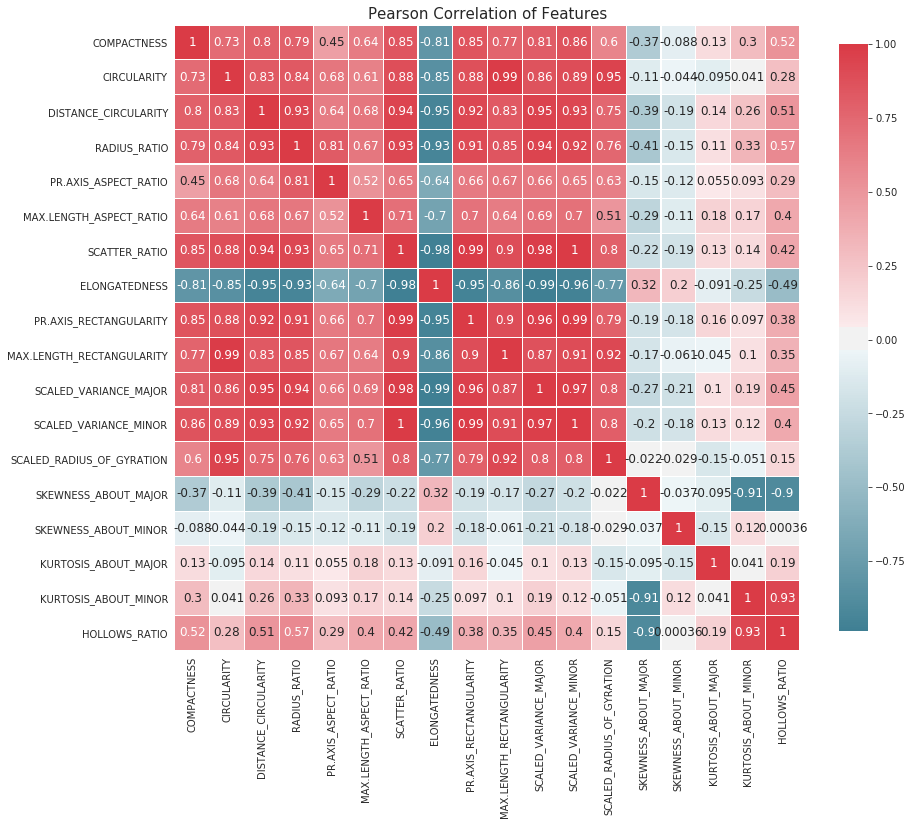

In [15]:
correlation_heatmap(X.iloc[list(outliers.keys())])

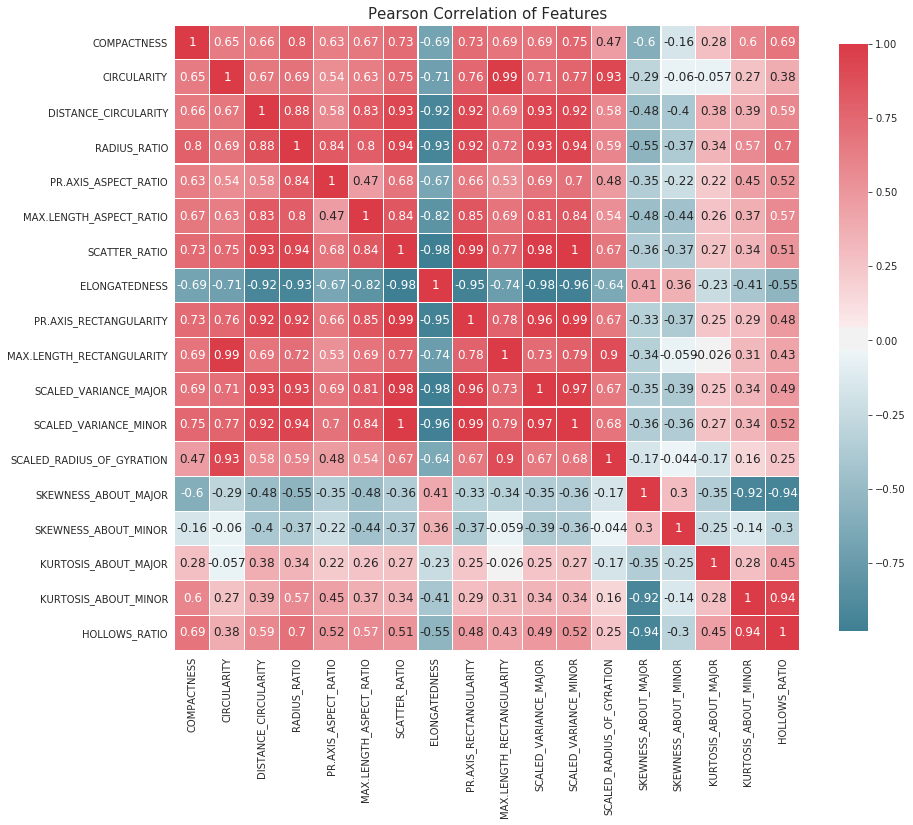

In [16]:
correlation_heatmap(X.iloc[list(significant.keys())])

The outliers and significant points do not seem to have very different feature correlation, which is alright because as I had already mentioned, outliers are indeed very important points, it is just that we are assigning a different category to them.

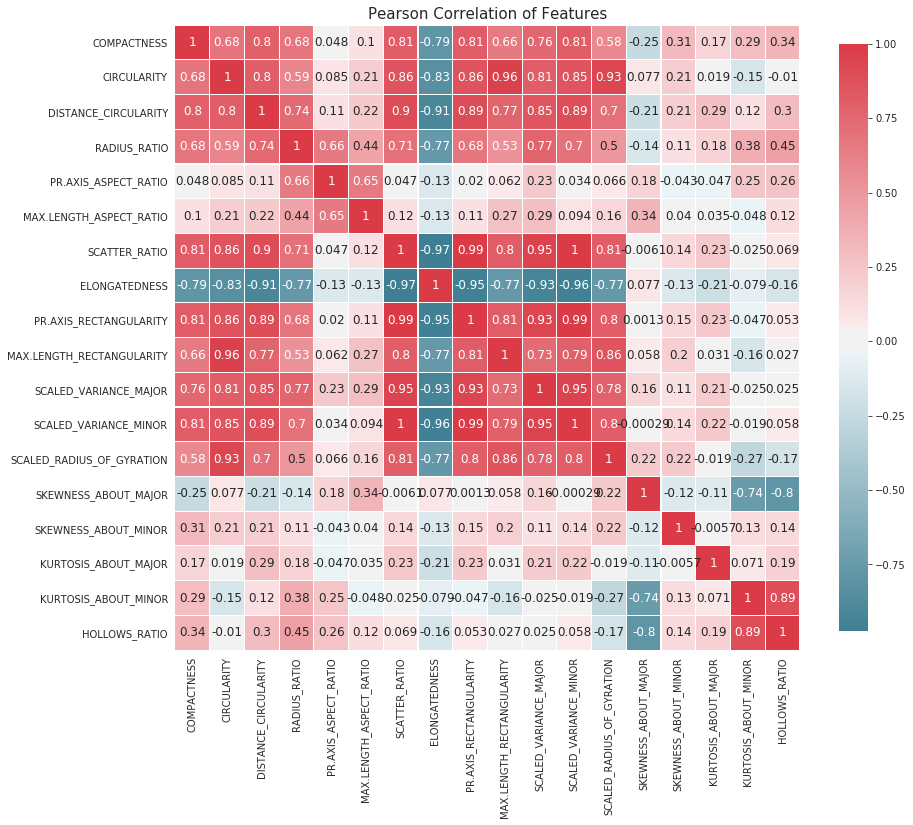

In [17]:
correlation_heatmap(X.iloc[list(insignificant.keys())])

Aha, there we go! A clear difference can be spotted with respect to the features ```PR_AXIS_ASPECT_RATIO``` and ```MAXLENGTH_ASPECT_RATIO```. So according to our assumption, one of these features should be the most important feature for this dataset, the truth of which we will now verify using a random forest classifier.

In [18]:
train_X, test_X, train_y, test_y = model_selection.train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

features = train_X.columns.values

rf_clf = ensemble.RandomForestClassifier(n_estimators=1000, max_features=18,
                                random_state=0)

rf_clf.fit(train_X, train_y)
feature_imp = rf_clf.feature_importances_

feature_imp_df =  pd.DataFrame()

feature_imp_df['Feature']= features
feature_imp_df['Importance']= feature_imp
feature_imp_df.sort_values(by=['Importance'], ascending=False)

,Feature,Importance
5,MAX.LENGTH_ASPECT_RATIO,0.183420
11,SCALED_VARIANCE_MINOR,0.123501
7,ELONGATEDNESS,0.117470
9,MAX.LENGTH_RECTANGULARITY,0.072566
0,COMPACTNESS,0.060507
2,DISTANCE_CIRCULARITY,0.047041
10,SCALED_VARIANCE_MAJOR,0.046713
14,SKEWNESS_ABOUT_MINOR,0.045462
17,HOLLOWS_RATIO,0.045071
15,KURTOSIS_ABOUT_MAJOR,0.043350


We can see that the most important feature here is indeed ```MAXLENGTH_ASPECT_RATIO``` :)

## Variance of the importance score

We have already obtained the importance score for each datapoint for each test fold it was present in. We have also calculated the mean and standard deviation (i.e., square root of variance) across all folds for each datapoint.

Now we will check the spread of the standard deviation to understand how sensitive the datapoints are w.r.t. to a slight alteration in the training set.

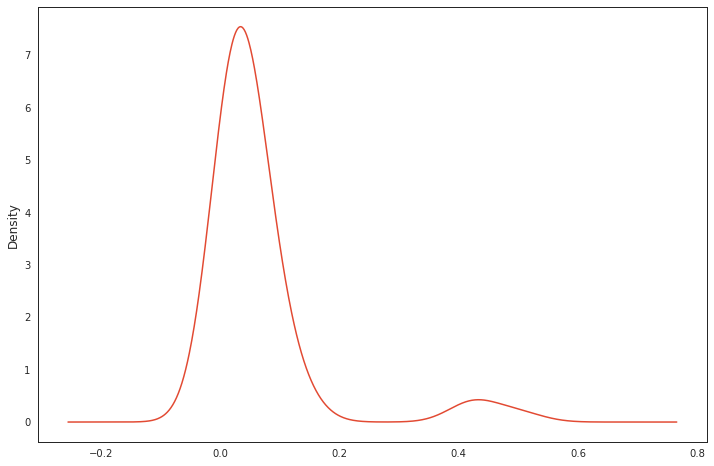

In [19]:
pd.DataFrame(outliers).iloc[1].plot.kde()

The standard deviation of outliers are mostly concentrated near 0, which means that regardless of the data used to train the model, an outlier will most likely remain an outlier.

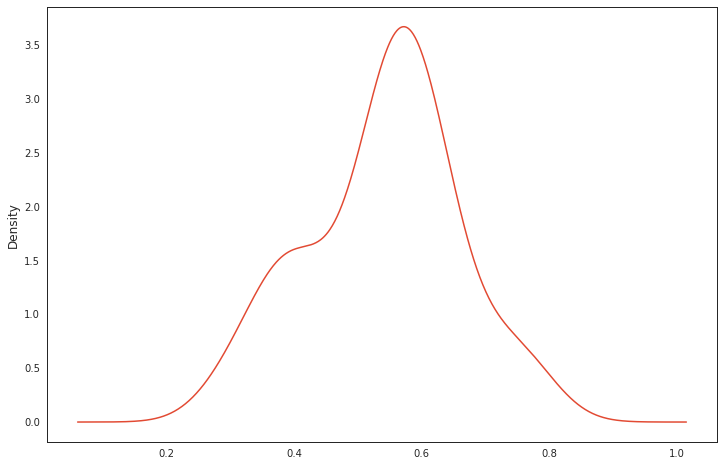

In [20]:
pd.DataFrame(significant).iloc[1].plot.kde()

A high standard deviation shows the unpredictable nature of the significant datapoints. This means that the same datapoint can be correctly or incorrectly classified with a low confidence score. This consolidates the fact that these *important* points do lie on the boundary of the classification distribution., which is why they are important in the first place.

This density distribution also clearly differentiates between outliers and non-outlier significant points.

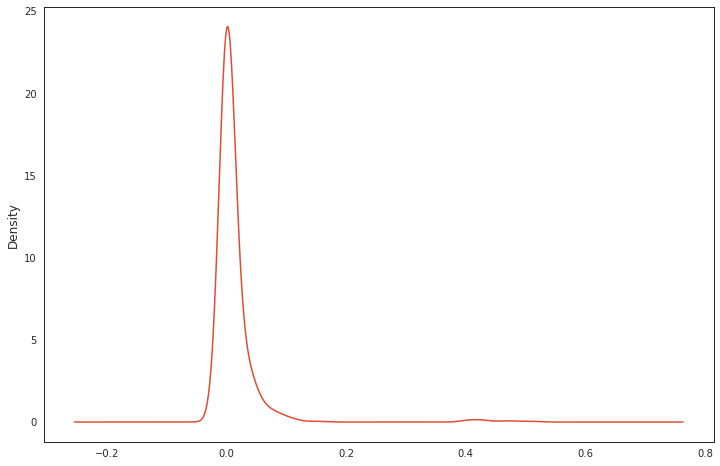

In [21]:
pd.DataFrame(insignificant).iloc[1].plot.kde()

Insignificant points lie at the centre of the classification distribution, which is further confirmed by the high density of insignificant points having a std deviation of almost 0. This is why they are insignificant on an individual level, but when all insignificant points are considered together, that chunk of data is actually what makes the model fit properly.

# Scope of further exploration

* Different classifiers can be used to see if our importance score is classifier agnostic
* The test size and stride can be varied and compared
* The model can be fitted only on the significant points and then tested on the rest to see what happens.